**Необходимо провести исследование различных способов представления документов и их влияние на качество определения тональности.**

**В качестве входных данных к лабораторной работе взят широко известный набор данных IMDB, содержащий 50K обзоров фильмов ([imdb-dataset-of-50k-movie-reviews](https://disk.yandex.ru/i/DDb0zuyUmts5QA)). Откликами являются значения двух классов positive и negative.**

In [ ]:
import pandas as pd
import inflect
import re
import pickle
import time
import datetime


import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words("english"))
infl = inflect.engine()
lemmatizer = WordNetLemmatizer()

imdb_data = pd.read_csv(r'IMDB Dataset.csv')
imdb_data.head(5)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Павел\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Павел\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Павел\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
imdb_data['review']

0        One of the other reviewers has mentioned that ...
1        A wonderful little production. <br /><br />The...
2        I thought this was a wonderful way to spend ti...
3        Basically there's a family where a little boy ...
4        Petter Mattei's "Love in the Time of Money" is...
                               ...                        
49995    I thought this movie did a down right good job...
49996    Bad plot, bad dialogue, bad acting, idiotic di...
49997    I am a Catholic taught in parochial elementary...
49998    I'm going to have to disagree with the previou...
49999    No one expects the Star Trek movies to be high...
Name: review, Length: 50000, dtype: object

#### Шаг №1 Подготовка данных

Обязательно предобработайте данные!



In [6]:
def process_text(text):
    text = text.lower()
    text = re.sub('\W',' ',text)

    pattern = re.compile(r'(\d+)')
    text = pattern.sub(lambda x: infl.number_to_words(x.group()), text).lower()
    tokens = word_tokenize(text)

    tokens = [lemmatizer.lemmatize(token,'v') for token in tokens if token not in stop_words]
    return " ".join(tokens)

In [7]:
imdb_data['processed_review'] = imdb_data['review'].apply(process_text)
imdb_data

,review,sentiment,processed_review
0,One of the other reviewers has mentioned that ...,positive,one reviewers mention watch one oz episode hoo...
1,A wonderful little production. <br /><br />The...,positive,wonderful little production br br film techniq...
2,I thought this was a wonderful way to spend ti...,positive,think wonderful way spend time hot summer week...
3,Basically there's a family where a little boy ...,negative,basically family little boy jake think zombie ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter mattei love time money visually stun fi...
...,...,...,...
49995,I thought this movie did a down right good job...,positive,think movie right good job creative original f...
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,bad plot bad dialogue bad act idiotic direct a...
49997,I am a Catholic taught in parochial elementary...,negative,catholic teach parochial elementary school nun...
49998,I'm going to have to disagree with the previou...,negative,go disagree previous comment side maltin one s...


In [106]:
train_size=0.5

train, _ = train_test_split(imdb_data, train_size = train_size, random_state=42)
train_x, train_y = train['processed_review'], train['sentiment']

В качестве исследуемых способов представления текстов необходимо рассмотреть:

#### 1.Компоненты вектора: частоты ([CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)).

In [107]:
vectorizer  = CountVectorizer()
vec_data_train = vectorizer.fit_transform(train_x)

#### 2. Компоненты вектора: оценки tf-idf для слова ([TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)).

In [108]:
tfidf = TfidfVectorizer()
tfidf_data_train = tfidf.fit_transform(train_x)

#### 3. Компоненты вектора: частоты N-грам.

In [109]:
ngram_vectorizer  = CountVectorizer(ngram_range=(2, 3))
ngram_vec_data_train = ngram_vectorizer.fit_transform(train_x)

### Шаг 2. Исследование моделей

<table>
		<tr>
			<td></td>
			<td>$y = 1$</td>
			<td>$y = 0$</td>
		</tr>
		<tr>
			<td>$a(x) = 1$</td>
			<td>True Positive (TP)</td>
			<td>False Positive (FP)</td>
		</tr>
    	<tr>
			<td>$a(x) = 0$</td>
			<td>False Negative (FN)</td>
			<td>True Negative (TN)</td>
		</tr>
</table>

В зависимости от способа представления оценить качество классификации как долю правильных ответов на выборке ($\operatorname{accuracy} = \frac{\operatorname{TP} + \operatorname{TN}}{\operatorname{TP} + \operatorname{TN} + \operatorname{FP} + \operatorname{FN}}$). Используйте перекрестную проверку ([cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html), [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html)).

Для каждого из нижеперечисленных моделей необходимо определить оптимальные гиперпараметры ([GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html))

Качество классификации оцениваем для следующих моделей:

#### 1. Машина опорных векторов ([SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)).

In [110]:
grid = pd.DataFrame(columns=['title', 'best_accuracy', 'best_params', 'execute_time', 'model'])

In [111]:
def MyGridSearchCV(params, components, X, Y, name=""):

    start_time = time.time()
    grid = GridSearchCV(components, params, n_jobs=8)
    grid.fit(X, Y)
    execute_time = datetime.timedelta(seconds=time.time() - start_time)

    print(f"{name}")
    print(f"Best params: {grid.best_params_}")
    print(f"Best accuracy: {grid.best_score_}")
    print(f"Time of execution: {execute_time}")
    print(f"------------------------------------------------------------")

    with open(f"saved_model/{name}.pkl", "wb") as fp:
        pickle.dump(grid, fp)

    return [ name, grid.best_score_, grid.best_params_, execute_time, grid]

In [112]:
svc_params={
    'C': [1,8,16],
    'kernel' : ['linear','rbf'],
    'gamma':[1, 0.1, 10]
}

svc = SVC()

grid.loc[0] = MyGridSearchCV( svc_params, svc, vec_data_train,       train_y, "SVC CountVectorizer")
grid.loc[1] = MyGridSearchCV( svc_params, svc, tfidf_data_train,     train_y, "SVC TF-IDF")
grid.loc[2] = MyGridSearchCV( svc_params, svc, ngram_vec_data_train, train_y, "SVC CountVectorizer ngramm")

SVC CountVectorizer
Best params: {'C': 1, 'gamma': 1, 'kernel': 'linear'}
Best accuracy: 0.8507999999999999
Time of execution: 2:26:58.438935
------------------------------------------------------------
SVC TF-IDF
Best params: {'C': 8, 'gamma': 1, 'kernel': 'rbf'}
Best accuracy: 0.89316
Time of execution: 2:11:28.698491
------------------------------------------------------------
SVC CountVectorizer ngramm
Best params: {'C': 1, 'gamma': 1, 'kernel': 'linear'}
Best accuracy: 0.8545999999999999
Time of execution: 4:54:44.338745
------------------------------------------------------------


#### 2. Случайный лес ([RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)).

In [113]:
rfc_params = {
    'n_estimators': [10, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [5, 10,20]
}
rfc = RandomForestClassifier()

grid.loc[3] = MyGridSearchCV( rfc_params, rfc, vec_data_train,       train_y, "RFC CountVectorizer")
grid.loc[4] = MyGridSearchCV( rfc_params, rfc, tfidf_data_train,     train_y, "RFC TF-IDF")
grid.loc[5] = MyGridSearchCV( rfc_params, rfc, ngram_vec_data_train, train_y, "RFC CountVectorizer ngramm")

RFC CountVectorizer
Best params: {'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 200}
Best accuracy: 0.8603999999999999
Time of execution: 0:08:02.445817
------------------------------------------------------------
RFC TF-IDF
Best params: {'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 200}
Best accuracy: 0.8559199999999999
Time of execution: 0:09:00.327574
------------------------------------------------------------
RFC CountVectorizer ngramm
Best params: {'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 200}
Best accuracy: 0.8340799999999999
Time of execution: 2:50:59.839375
------------------------------------------------------------


### Шаг 3. Сравнение результатов

Сравнить точность обученных моделей. Найти наиболее точную.

In [125]:
sorted_grid = grid.sort_values(by='best_accuracy', ascending=False)
sorted_grid

,title,best_accuracy,best_params,execute_time,model
1,SVC TF-IDF,0.89316,"{'C': 8, 'gamma': 1, 'kernel': 'rbf'}",0 days 02:11:28.698491,"GridSearchCV(estimator=SVC(), n_jobs=8,\n ..."
3,RFC CountVectorizer,0.86040,"{'max_depth': None, 'min_samples_leaf': 5, 'mi...",0 days 00:08:02.445817,GridSearchCV(estimator=RandomForestClassifier(...
4,RFC TF-IDF,0.85592,"{'max_depth': None, 'min_samples_leaf': 5, 'mi...",0 days 00:09:00.327574,GridSearchCV(estimator=RandomForestClassifier(...
2,SVC CountVectorizer ngramm,0.85460,"{'C': 1, 'gamma': 1, 'kernel': 'linear'}",0 days 04:54:44.338745,"GridSearchCV(estimator=SVC(), n_jobs=8,\n ..."
0,SVC CountVectorizer,0.85080,"{'C': 1, 'gamma': 1, 'kernel': 'linear'}",0 days 02:26:58.438935,"GridSearchCV(estimator=SVC(), n_jobs=8,\n ..."
5,RFC CountVectorizer ngramm,0.83408,"{'max_depth': None, 'min_samples_leaf': 5, 'mi...",0 days 02:50:59.839375,GridSearchCV(estimator=RandomForestClassifier(...


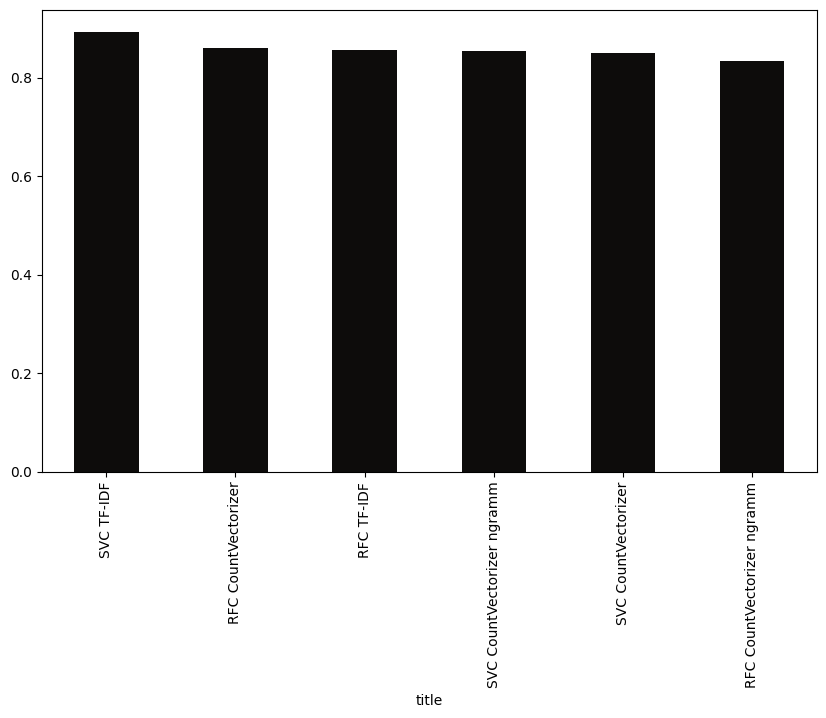

In [126]:
sorted_grid.plot.bar(x='title', y='best_accuracy', color='#0D0C0B', figsize=(10, 6), legend=False);

In [4]:
# best_model = sorted_grid.iloc[0]['model'].best_estimator_
best_model = SVC(C=8,gamma=1,kernel='rbf')

In [8]:
tfidf = TfidfVectorizer()

train_, test_ = train_test_split(imdb_data, train_size = 0.8, random_state=42)
train_X, train_Y = tfidf.fit_transform(train_['processed_review']), train_['sentiment']
test_X, test_Y = tfidf.fit_transform(train_['processed_review']), train_['sentiment']

In [135]:
best_model.fit(train_X, train_Y)

SVC(C=8, gamma=1)

In [9]:
accuracy_scores = cross_val_score(best_model, test_X, test_Y, scoring='accuracy', n_jobs=8)
print(f"Точность на тестовой выборке: {accuracy_scores.mean()}")

Точность на тестовой выборке: 0.9005750000000001
